In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time

# Config

In [ ]:
# Station and wharves dataframe
wharf_df = pd.read_csv('csv_inputs/wharf_info.csv')
# lines dataframe
line_df = pd.read_csv('csv_inputs/line_info.csv')
line_df['First_sailing'] = pd.to_datetime(line_df['First_sailing'], format='%H:%M')
# Wharf to wharf transit time dataframe
tt_df = pd.read_csv('csv_inputs/rebalancing_times.csv',index_col='From/To')
# Headways dataframe
headway_df = pd.read_csv('csv_inputs/headways.csv')
# vessels
vessel_df = pd.read_csv('csv_inputs/vessel_info.csv')
# charging berths dataframe
charging_berth = pd.read_csv('csv_inputs/charging_berths.csv')

# Simulation time parameters
initial_time = time(5,30)
period_length = 5  # mins
total_operation_hours = 6  # hours

# nc, Minimum num of crew breaks
nc = 1

# Dc, Crew break duration (fixed)
Dc = 30  # mins

# Tc, Maximum separation time for crew breaks
Tc = 6 * 60  # mins

# rv+, charging rate
rv_plus = 0.159 # 2100 * period_length / 60 / 1100  # kW*h/kWh --> %

# pc, Plugging/Unplugging time
pc = 1  # mins # reivsed by 11 Oct after checking the originla data for charging



# Functions

In [3]:
def cal_time(period_num):
    """
    Calculates a new datetime based on an initial time and a given number of periods.
    
    Args:
    period_num (int): The period number to calculate the time for.
    initial_time (datetime.time): The starting time of the calculation.
    period_length (int): The length of each period in minutes.
    
    Returns:
    datetime.datetime: The calculated datetime.
    """
    # Convert initial_time to a datetime object with today's date
    initial_datetime = datetime.combine(datetime.today(), initial_time)
    
    # Calculate the total minutes to add
    added_time = timedelta(minutes=int((period_num - 1) * period_length))
    new_time = initial_datetime + added_time

    return new_time


In [4]:
print(cal_time(41
               ))

2024-12-16 08:50:00


In [5]:
def cal_duration(minutes):
    result = (minutes // 5) + (1 if minutes % 5 != 0 else 0)
    return int(result)

def cal_h(s, d, l): # headways
    try:
        h = headway_df[f'h{l}'].dropna().tolist()
        h_sd_ls = [d]  # Start the list with the initial day 'd'
        for sailing_headway in h:
            num_time_period = cal_duration(sailing_headway)
            h_sd_ls.append(h_sd_ls[-1] + num_time_period)
        if s-1 < len(h_sd_ls):
            return h_sd_ls[s-1]
        else:
            return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [6]:
# Functions to replace and determine wharfs
# def start_wharf(task):
#     if task.isdigit():
#         return Start_wharf[int(task)]
#     return task
def start_wharf(task):
    # Ensure task is a string key for the dictionary lookup
    if task.isdigit():
        task_str = task  # Keep task as string to match dictionary key
        if task_str in Start_wharf:
            return Start_wharf[task_str]
        else:
            # Handle missing key case
            print(f"Key {task_str} not found in Start_wharf, using default.")
            return 'Unknown Wharf'
    return task

def end_wharf(row):
    wharf = row['End_Wharf']
    if row['Task'].isdigit():
        line = int(row['Task'])
        timetoT = int(line_df[line_df['Line_No'] == line]['Time_underway_to_T'].iloc()[0])
        end_time = row['Start_Time'] + timetoT // period_length + 1
        matching_rows = Zp_df[(Zp_df['Line'] == line) & (Zp_df['Time'] == end_time)]
        if not matching_rows.empty:
            wharf = matching_rows['Wharf'].iloc()[0]
    return wharf

def end_time(row):
    if row['Task'].isdigit():
        line = int(row['Task'])
        duration = int(line_df[line_df['Line_No'] == line]['Line_duration'].iloc()[0])
        return (cal_time(row['Start_Time']) + timedelta(minutes=duration)).strftime('%H:%M')
    elif row['Task'] in ['Waiting', 'Charging']:
        return (cal_time(row['Start_Time']) + timedelta(minutes=5)).strftime('%H:%M')
    else:
        return (cal_time(row['Start_Time']) + timedelta(minutes=Dc)).strftime('%H:%M')

# Load results files

In [8]:
def load_and_process_data(filepath, split_columns, value_columns):
    """
    Load data, remove unwanted characters, filter rows, split columns, and convert types.

    Args:
    filepath (str): Path to the CSV file.
    split_columns (list): List of columns names after splitting the 'Variable' column.
    value_columns (dict): Dictionary of columns to convert with their respective types.
    """
    df = pd.read_csv(filepath)
    df = df[df['Value'] == 1]
    # df['Variable'] = df['Variable'].str.replace(r"[()']", "", regex=True)
    df['Variable'] = df['Variable'].str.replace(r"[()' ]", "", regex=True)
    df[split_columns] = df['Variable'].str.split(',', expand=True)
    for column, dtype in value_columns.items():
        df[column] = df[column].astype(dtype)
    return df


# # Load and process each DataFrame using the new function

# file_prefix = "6htest_new_cyclelines_v6"

file_prefix = "6htest_v6"

z_df = load_and_process_data(f'output_files/{file_prefix}_z_wj_results.csv',['Wharf', 'Task'],{})

Zp_df = load_and_process_data(f'output_files/{file_prefix}_Z_prime_lwt_results.csv',['Line', 'Wharf', 'Time'],{'Line': int, 'Time': int})

Z_df = load_and_process_data(f'output_files/{file_prefix}_Z_lwt_results.csv',['Line', 'Wharf', 'Time'],{'Line': int, 'Time': int})

Start_S = dict(zip(line_df['Line_No'].astype(str), line_df['O']))
Start_S.update(dict(zip(wharf_df['Wharf_No'], wharf_df['Station'])))
End_S = dict(zip(line_df['Line_No'].astype(str), line_df['T']))
End_S.update(dict(zip(wharf_df['Wharf_No'], wharf_df['Station'])))

# Start_wharf = dict(zip(z_df['Line'].astype(str), z_df['Wharf']))
linels = z_df['Task'].unique().tolist()

Start_wharf = {}
for line in linels:
    Start_wharf[line] = z_df[z_df['Task'] == str(line)]['Wharf'].iloc[0]

In [9]:
split_columns = ['Vessel', 'Time']
value_columns = {'Vessel': str, 'Time': int}

q_df = pd.read_csv(f'output_files/{file_prefix}_Q_vt_results.csv')

# df['Variable'] = df['Variable'].str.replace(r"[()']", "", regex=True)
q_df['Variable'] = q_df['Variable'].str.replace(r"[()' ]", "", regex=True)
q_df[split_columns] = q_df['Variable'].str.split(',', expand=True)
for column, dtype in value_columns.items():
    q_df[column] = q_df[column].astype(dtype)

q_df = q_df[['Vessel', 'Time', 'Value']]
q_df['Time'] = q_df['Time'].apply(lambda x: cal_time(x).strftime('%H:%M'))


In [10]:
def cal_battery_change(vessel):
    split_columns = ['Vessel', 'Time']
    value_columns = {'Vessel': str, 'Time': int}

    q_df = pd.read_csv(f'output_files/{file_prefix}_Q_vt_results.csv')

    q_df['Variable'] = q_df['Variable'].str.replace(r"[()' ]", "", regex=True)
    q_df[split_columns] = q_df['Variable'].str.split(',', expand=True)
    for column, dtype in value_columns.items():
        q_df[column] = q_df[column].astype(dtype)

    q_df = q_df[['Vessel', 'Time', 'Value']]
    q_df['Time'] = q_df['Time'].apply(lambda x: cal_time(x).strftime('%H:%M'))
    Qv1 = q_df[q_df['Vessel'] == vessel]
    Qv1


# Timetable

In [11]:
# Load and preprocess x_df
# x_df = load_and_process_data('output_files/x_ld_results.csv',['Line', 'Time'],{'Line': int, 'Time': int})
x_df = load_and_process_data(f'output_files/{file_prefix}_x_ld_results.csv',['Line', 'Time'],{'Line': int, 'Time': int})


# List of lines from line_df and x_df
lines = line_df['Line_No'].unique().tolist()
solved_lines = x_df['Line'].unique().tolist()

def cal_timetable(line):
    # Check if the line exists and is solved
    if line in lines and line in solved_lines:
        # First sailing time and headways
        d = x_df.loc[x_df['Line'] == line, 'Time'].iloc[0]
        headways = headway_df[f'h{line}'].dropna().tolist()

        times, locs, wharfs = [], [], []
        
        # Calculate timings for all sailings including first and subsequent ones
        for s in range(len(headways)+1):
            period = cal_h(s+1, d, line)  # Assuming cal_h is defined somewhere
            sailing_time = cal_time(period)
            
            # Add sailing time, location and wharf
            times.append(sailing_time)
            locs.append(Start_S[str(line)])
            wharfs.append(z_df[z_df['Task'] == str(line)]['Wharf'].iloc[0])

            # Intermediate Stop
            Intermediate_stop = line_df[line_df['Line_No'] == line]['I'].iloc[0]
            if pd.notna(Intermediate_stop):
                timetoI = int(line_df[line_df['Line_No'] == line]['Time_underway_to_I'].iloc[0])
                arrival_time_I = sailing_time + timedelta(minutes=timetoI)
                times.append(arrival_time_I)
                locs.append(Intermediate_stop)
                wharfs.append(z_df[z_df['Task'] == str(line)]['Wharf'].iloc[1])
            
            # Terminal Stop
            timetoT = int(line_df[line_df['Line_No'] == line]['Time_underway_to_T'].iloc[0])

            arrival_time_T = sailing_time + timedelta(minutes=timetoT)
            times.append(arrival_time_T)
            locs.append(End_S[str(line)])

            filtered_df = Zp_df[(Zp_df['Line'] == line) & (Zp_df['Time'] == period + cal_duration(timetoT))]

            # Check if filtered_df is not empty before accessing .iloc[0]
            if not filtered_df.empty:
                wharfs.append(filtered_df['Wharf'].iloc[0])
            else:
                print(f"No matching data found for line {line} and time {period + cal_duration(timetoT)}")
                # Handle the case when no match is found, e.g., append a placeholder or skip
                wharfs.append('No Wharf Found')  # or any other placeholder

            # wharfs.append(Zp_df[(Zp_df['Line'] == line) & (Zp_df['Time'] == period + timetoT // period_length + 1)]['Wharf'].iloc[0])

        # Format times and create the DataFrame
        formatted_times = [time.strftime('%H:%M') for time in times]
        timetable = pd.DataFrame({
            'Time': formatted_times,
            'Station': locs,
            'Wharf': wharfs
        })
        return timetable
    
    else:
        print('Line not exist or unsolved.')
        return None

cal_timetable(2)

,Time,Station,Wharf
0,06:00,Circular Quay,CQ4
1,06:28,Pyrmont Bay,PB1
2,07:05,Circular Quay,CQ5
3,06:20,Circular Quay,CQ4
4,06:48,Pyrmont Bay,PB1
5,07:25,Circular Quay,CQ1
6,06:40,Circular Quay,CQ4
7,07:08,Pyrmont Bay,PB1
8,07:45,Circular Quay,CQ3
9,07:00,Circular Quay,CQ4


# Vessel itinerary

In [12]:
# Load data
y_df = load_and_process_data(f'output_files/{file_prefix}_y_vjt_results.csv',['Vessel', 'Task', 'Start_Time'],{'Start_Time': int})

Bplus = ['CQ2', 'CQ4', 'CQ5', 'Bar1', 'Bar2']
Bc = ['cp_CQ1', 'cp_CQ2', 'cp_CQ3', 'cp_CQ4', 'cp_CQ5', 'cp_Bar1', 'cp_Bar2', 'cp_Bar4', 'cp_Bar5', 'cp_BSY1', 'cp_BSY2', 'cp_BSY3', 'cp_BSY4', 'cp_BSY5', 'cp_BSY6']
B = ['CQ1', 'CQ3', 'CI1', 'Bar4', 'Bar5', 'PB1', 'Mos1', 'TZ1', 'WB1', 'RB1', 'DB1', 'BSY1', 'BSY2', 'BSY3', 'BSY4', 'BSY5', 'BSY6', 'BWB1', 'NB1', 'phi_CQ2', 'phi_CQ4', 'phi_CQ5', 'phi_Bar1', 'phi_Bar2']



In [13]:
line_to_route_dict = {
    '1': 'F2 - Taronga Zoo',
    '2': 'F4 - Pyrmont Bay',
    '3': 'F5 - Neutral Bay',
    '4': 'F6 - Mosman',
    '5': 'F7 - Double Bay',
    '6': 'F8 - Cockatoo Island',
    '7': 'F9 - Rose Bay',
    '8': 'F9 - Watsons Bay',
    '9': 'F11 - Blackwattle Bay'}


In [14]:
vessel = "V8"
vessel_itinerary_df = y_df.copy()
# Extract and clean up Wharf details
vessel_itinerary_df['Start_Wharf'] = vessel_itinerary_df['Task'].apply(lambda x: x.split('_')[-1].strip())
vessel_itinerary_df['End_Wharf'] = vessel_itinerary_df['Start_Wharf']

# Lookup Start and End Stations based on Wharfs
vessel_itinerary_df['Start_Station'] = vessel_itinerary_df['Start_Wharf'].apply(lambda x: Start_S.get(x, 'Unknown Station'))
vessel_itinerary_df['End_Station'] = vessel_itinerary_df['Start_Wharf'].apply(lambda x: End_S.get(x, 'Unknown Station'))

# Update Task based on specific keywords or conditions
# vessel_itinerary_df['Task'] = vessel_itinerary_df['Task'].apply(lambda x: 'Waiting' if x in B else
#                                                                             'Crew Break' if x in Bc else
#                                                                             'Charging' if x in Bplus else
#                                                                             f"{x}")
vessel_itinerary_df['Task'] = vessel_itinerary_df['Task'].apply(
    lambda x: 'Waiting' if x in B and not x.startswith('phi_') else
              'Charging' if x in B and x.startswith('phi_') else
              'Crew Break' if x in Bc else
              'Charging' if x in Bplus else
              f"{x}"
)
# Initial transformations for Start_Wharf and End_Wharf 
vessel_itinerary_df['Start_Wharf'] = vessel_itinerary_df['Start_Wharf'].apply(start_wharf)
vessel_itinerary_df['End_Wharf'] = vessel_itinerary_df['Start_Wharf']

vessel_itinerary_df['End_Wharf'] = vessel_itinerary_df.apply(end_wharf, axis=1)
vessel_itinerary_df['End_Time'] = vessel_itinerary_df.apply(end_time, axis=1)


# Reorganize DataFrame columns for final output
vessel_itinerary_df = vessel_itinerary_df[['Vessel', 'Task', 'Start_Station', 'Start_Wharf', 'Start_Time', 'End_Station', 'End_Wharf', 'End_Time']]

# Function to calculate vessel itinerary

itinerary = vessel_itinerary_df[vessel_itinerary_df['Vessel'] == vessel].sort_values('Start_Time')
itinerary['Start_Time'] = itinerary['Start_Time'].apply(lambda x: cal_time(x).strftime('%H:%M'))
itinerary.reset_index(inplace=True, drop=True)

itinerary['Task'] = itinerary['Task'].replace(line_to_route_dict)

itinerary

,Vessel,Task,Start_Station,Start_Wharf,Start_Time,End_Station,End_Wharf,End_Time
0,V8,Crew Break,Balmain Shipyard,BSY5,05:40,Balmain Shipyard,BSY5,06:10
1,V8,Waiting,Balmain Shipyard,BSY3,06:10,Balmain Shipyard,BSY3,06:15
2,V8,Waiting,Balmain Shipyard,BSY4,06:15,Balmain Shipyard,BSY4,06:20
3,V8,Charging,Circular Quay,CQ2,06:35,Circular Quay,CQ2,06:40
4,V8,Waiting,Circular Quay,CQ1,06:40,Circular Quay,CQ1,06:45
5,V8,Charging,Circular Quay,CQ4,06:45,Circular Quay,CQ4,06:50
6,V8,Waiting,Circular Quay,CQ3,06:50,Circular Quay,CQ3,06:55
7,V8,10,Circular Quay,CQ2,06:55,Circular Quay,CQ4,07:47
8,V8,Charging,Circular Quay,CQ2,07:50,Circular Quay,CQ2,07:55
9,V8,F7 - Double Bay,Circular Quay,CQ3,07:55,Circular Quay,CQ2,08:45


# Wharfs utilisations


In [14]:
# # non line task
non_line_tasks = y_df[~y_df['Task'].str.match(r'^\d+$')]
data = []

for _, row in non_line_tasks.iterrows():
    v = row['Vessel']
    j = row['Task']
    w = row['Task'].split('_')[-1]
    t = row['Start_Time'] # "12:00"
    
    start = cal_time(t)
    if j in Bc: # crew break
        end = start + timedelta(minutes=Dc)
    elif j in Bplus or j in B: # charging
        end = start + timedelta(minutes=5)
    else:
        print(f'{v},{j},{w},{t}: Error')

        # Add data for origin
    data.append({
        "Vessel": v,
        "Task": j,
        "Wharf": w,
        "Time": f"{start.strftime('%H:%M')}-{end.strftime('%H:%M')}"
    })
non_line_tasks

,Variable,Value,Vessel,Task,Start_Time
1019,"V18,Bar4,12",1.0,V18,Bar4,12
1647,"V18,BSY1,64",1.0,V18,BSY1,64
2303,"V18,phi_CQ4,72",1.0,V18,phi_CQ4,72
2374,"V18,phi_CQ5,71",1.0,V18,phi_CQ5,71
2385,"V18,phi_Bar1,10",1.0,V18,phi_Bar1,10
...,...,...,...,...,...
73564,"V17,phi_CQ4,53",1.0,V17,phi_CQ4,53
73565,"V17,phi_CQ4,54",1.0,V17,phi_CQ4,54
73582,"V17,phi_CQ4,71",1.0,V17,phi_CQ4,71
73650,"V17,phi_CQ5,67",1.0,V17,phi_CQ5,67


In [15]:

line_tasks = y_df[y_df['Task'].str.match(r'^\d+$')]
for _, row in line_tasks.iterrows():
    v = row['Vessel']  # Vessel name
    j = int(row['Task'])  # Task number (Line_No)
    t = row['Start_Time']  # Start time (assuming it's in a compatible format)

    # Origin
    # w_start = line_df[line_df['Line_No'] == j]['O'].iloc[0]
    w_start = z_df[z_df['Task'] == str(j)]['Wharf'].iloc[0]
    dwell_O = int(line_df[line_df['Line_No'] == j]['dw_O'].iloc[0])

    start_O = cal_time(t)
    end_O = start_O + timedelta(minutes=dwell_O)

    # Add data for origin
    data.append({
        "Vessel": v,
        "Task": j,
        "Wharf": w_start,
        "Time": f"{start_O.strftime('%H:%M')}-{end_O.strftime('%H:%M')}"
    })

    # Intermediate Stop
    intermediate_station = line_df[line_df['Line_No'] == j]['I']
    if pd.notna(intermediate_station).any():
        w_intermediate = z_df[z_df['Task'] == str(j)]['Wharf'].iloc[1]  # Wharf
        time_to_I = int(line_df[line_df['Line_No'] == j]['Time_underway_to_I'].iloc[0])
        dwell_I = int(line_df[line_df['Line_No'] == j]['dw_I'].iloc[0])

        start_I = start_O + timedelta(minutes=time_to_I)
        end_I = start_I + timedelta(minutes=dwell_I)

        data.append({
            "Vessel": v,
            "Task": j,
            "Wharf": w_intermediate,
            "Time": f"{start_I.strftime('%H:%M')}-{end_I.strftime('%H:%M')}"
        })

    # Terminus
    time_to_T = int(line_df[line_df['Line_No'] == j]['Time_underway_to_T'].iloc[0])
    dwell_T = int(line_df[line_df['Line_No'] == j]['dw_T'].iloc[0])

    start_T = start_O + timedelta(minutes=time_to_T)
    end_T = start_T + timedelta(minutes=dwell_T)

    filtered_wharfs = Zp_df[(Zp_df['Line'] == j) & (Zp_df['Time'] == t + cal_duration(time_to_T))]['Wharf'].unique().tolist()
    if filtered_wharfs:
        w_end = filtered_wharfs[0]
    else:
        print(f"No matching wharf found for line {j} at time {t + cal_duration(time_to_T)}")
        w_end = None  # Handle missing value appropriately

    data.append({
        "Vessel": v,
        "Task": j,
        "Wharf": w_end,
        "Time": f"{start_T.strftime('%H:%M')}-{end_T.strftime('%H:%M')}"
    })

    # Convert the list of dictionaries to a DataFrame
    wharf_occupation_df = pd.DataFrame(data)

# Display the result
wharf_occupation_df


,Vessel,Task,Wharf,Time
0,V18,Bar4,Bar4,06:25-06:30
1,V18,BSY1,BSY1,10:45-10:50
2,V18,phi_CQ4,CQ4,11:25-11:30
3,V18,phi_CQ5,CQ5,11:20-11:25
4,V18,phi_Bar1,Bar1,06:15-06:20
...,...,...,...,...
457,V17,7,RB1,06:09-06:19
458,V17,7,CQ2,06:32-06:36
459,V17,7,CQ3,07:55-07:56
460,V17,7,RB1,08:09-08:19


In [16]:
wharf_df = wharf_occupation_df[wharf_occupation_df['Wharf'] == 'CQ1'].copy()
# wharf_df['Task'] = wharf_df['Task'].apply(lambda x: 'Waiting' if x in B else
#                                             'Crew Break' if x in Bc else
#                                             'Charging' if x in Bplus else
#                                             f"{x}")


wharf_df['Task'] = wharf_df['Task'].apply(
    lambda x: 'Waiting' if x in B and not x.startswith('phi_') else
              'Charging' if x in B and x.startswith('phi_') else
              'Crew Break' if x in Bc else
              'Charging' if x in Bplus else
              f"{x}"
)

wharf_df.reset_index(drop=True)
wharf_df['Task'] = wharf_df['Task'].replace(line_to_route_dict)

wharf_df = wharf_df.sort_values('Time')
wharf ='CQ1'


wharf_df

,Vessel,Task,Wharf,Time
10,V19,Waiting,CQ1,05:40-05:45
176,V12,Crew Break,CQ1,05:40-06:10
225,V16,Crew Break,CQ1,05:45-06:15
194,V15,Waiting,CQ1,06:15-06:20
387,V11,F8 - Cockatoo Island,CQ1,06:20-06:21
323,V5,F5 - Neutral Bay,CQ1,06:42-06:45
64,V5,Waiting,CQ1,06:45-06:50
351,V7,F8 - Cockatoo Island,CQ1,06:50-06:51
422,V14,F9 - Rose Bay,CQ1,06:52-06:56
401,V12,F9 - Rose Bay,CQ1,07:12-07:16


In [17]:
v = 'V18' 
j = 9 # line task test 
t = 10

# origin
w_start = line_df[line_df['Line_No'] == j]['O'].iloc[0]
dwell_O = int(line_df[line_df['Line_No'] == j]['dw_O'].iloc[0])  # CHANGE

# safety_buffer = 5 # MINS # CHANGE
start_O = cal_time(t)
end_O = start_O + timedelta(minutes=dwell_O)

print(f'v: {v}, j: {j},w: {w_start}, t_start: {start_O}, t_end: {end_O}')

# intermidiate stop
intermediate_station = line_df[line_df['Line_No'] == j]['I']
if pd.notna(intermediate_station).any():
    w_intermediate = z_df[z_df['Task'] == str(j)]['Wharf'].iloc[1] # wharf
    time_to_I = int(line_df[line_df['Line_No'] == j]['Time_underway_to_I'].iloc[0])
    dwell_I = int(line_df[line_df['Line_No'] == j]['dw_I'].iloc[0])

    start_I = start_O + timedelta(minutes=time_to_I)
    end_I = start_I + timedelta(minutes=dwell_I)

    print(f'v: {v}, j: {j},w: {w_intermediate}, t_start: {start_I}, t_end: {end_I}')

# terminus
time_to_T = int(line_df[line_df['Line_No'] == j]['Time_underway_to_T'].iloc[0])
dwell_T = int(line_df[line_df['Line_No'] == j]['dw_T'].iloc[0])

start_T = start_O + timedelta(minutes = time_to_T)
end_T = start_T + timedelta(minutes = dwell_T)


########################## REMARK ###########################
filtered_wharfs = Zp_df[(Zp_df['Line'] == j) & (Zp_df['Time'] == t + cal_duration(time_to_T))]['Wharf'].unique().tolist() ###  wharf check wharf need revise


# Check if the list is not empty before accessing the first element
if filtered_wharfs:
    w_end = filtered_wharfs[0]
else:
    print(f"No matching wharf found for line {j} at time {t + cal_duration(time_to_T)}")
    w_end = None  # Or set a default value or take another appropriate action

print(f'v: {v}, j: {j},w: {w_end}, t_start: {start_T}, t_end: {end_T}')


v: V18, j: 9,w: Barangaroo, t_start: 2024-12-03 06:15:00, t_end: 2024-12-03 06:16:00
v: V18, j: 9,w: BWB1, t_start: 2024-12-03 06:37:00, t_end: 2024-12-03 06:47:00
No matching wharf found for line 9 at time 21
v: V18, j: 9,w: None, t_start: 2024-12-03 07:08:00, t_end: 2024-12-03 07:11:00


In [ ]:
Lset = line_df['Line_No'].unique().tolist()
Vset = vessel_df['Vessel code'].unique().tolist()
rv = {v: vessel_df[vessel_df['Vessel code'] == v]['rv'].iloc[0] for v in Vset}
def cal_q(v,j,t): # require update when simulating charging 
    if j in Bc: # crew pause
        return 0

    elif j in Bplus: # Charging
        return rv_plus
    
    elif j in B :
        if 'phi_' in j: # fisr/last period of charging
            epsilon = 1 - pc / period_length
            return epsilon * rv_plus
        else:   # waiting   
            return 0
        
    elif j in Lset: # line task
        l = j
        line_data = line_df[line_df['Line_No'] == l]
        return line_data['rj'].iloc()[0]
    
    else: # rebalancing
        return rv[v] 

(0.0, 72.0)

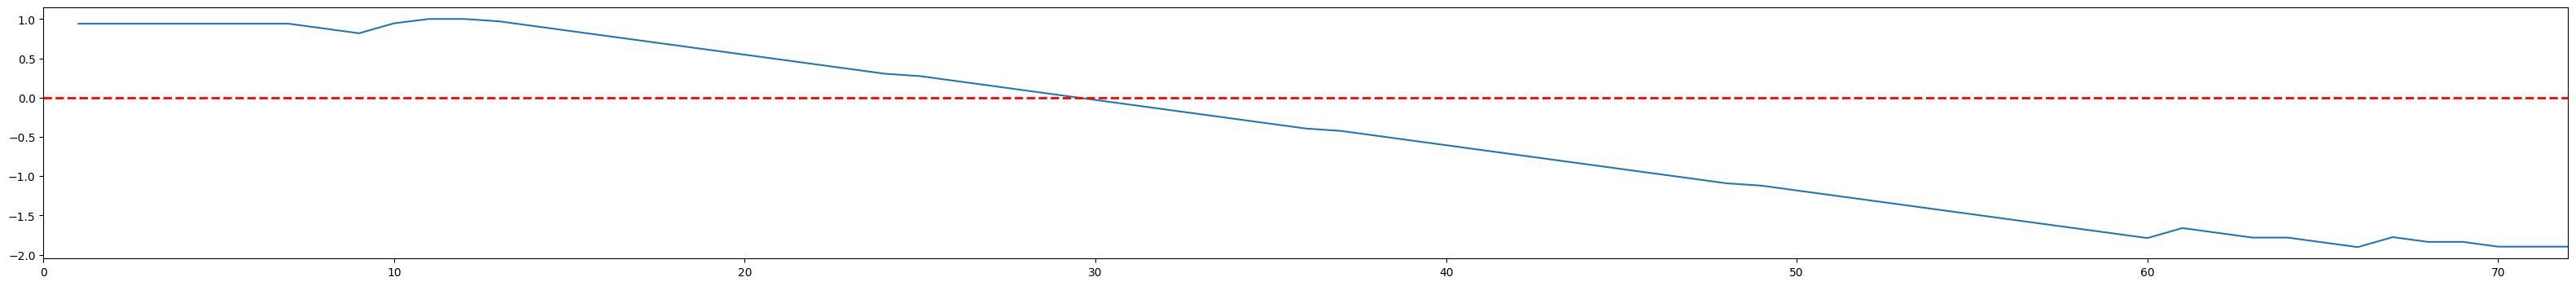

In [78]:
import matplotlib.pyplot as plt

V8 = y_df[y_df['Vessel'] == 'V18'][['Vessel','Task','Start_Time']].copy()
V8

filled_times = pd.DataFrame({'Start_Time': list(range(1, 73))})
result_df = filled_times.merge(V8, on='Start_Time', how='left')
result_df['Task'] = result_df['Task'].fillna("")
result_df['Vessel'] = result_df['Vessel'].fillna("V8")
result_df['Battery_Change'] = result_df.apply(lambda row: cal_q(row['Vessel'], row['Task']), axis=1)

# Handle the condition where Task is in Bc
for idx in result_df.index:
    if result_df.loc[idx, 'Task'] in Bc:
        # Set Battery_Change to 0 for the next 6 time periods (if within bounds)
        result_df.loc[idx:idx + 5, 'Battery_Change'] = 0
# Initialize battery level column
result_df['Battery_Level'] = 0  # Assuming battery starts at 0

# Set initial battery level
initial_battery_level = 1
max_battery_level = 1.0

# Calculate battery levels with constraints
current_battery_level = initial_battery_level

for idx in result_df.index:
    # Update battery level based on the previous level and the current change
    current_battery_level += result_df.loc[idx, 'Battery_Change']
    
    # Apply constraints
    if current_battery_level > max_battery_level:
        current_battery_level = max_battery_level
    # elif current_battery_level < 0:
    #     current_battery_level = 0
    
    # Save the calculated battery level
    result_df.loc[idx, 'Battery_Level'] = current_battery_level

fig, ax = plt.subplots(figsize=(40,4), dpi=100)
plt.plot(result_df.Start_Time, result_df.Battery_Level)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Safety Minimum Allowance')

plt.xlim(0, 72)
# plt.ylim(-1, 1)


In [76]:
V8

,Vessel,Task,Start_Time
588,V18,9,13
600,V18,9,25
612,V18,9,37
624,V18,9,49
1019,V18,Bar4,12
1150,V18,Bar5,71
1151,V18,Bar5,72
1220,V18,PB1,69
1647,V18,BSY1,64
2442,V18,phi_Bar1,67
